In [1]:
%%capture
# Install the latest Tensorflow version.
!pip install tensorflow_text
!pip install bokeh
!pip install simpleneighbors[annoy]
!pip install tqdm
!pip install unidecode

In [2]:
import os,re,collections
import numpy as np

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU,LSTM, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
import tensorflow.compat.v2 as tf
import pickle

In [ ]:
import zipfile
from google.colab import drive


#nous allons extraire nos données qui se trouvent dans un fichier zip dans notre drive 
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/rebuilt.Cross-Language-Dataset-master.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [4]:
#nous allons experimenter une partie de nos donnée dans cette partie on commence par le corpus APR 
English_Dataset = tf.data.Dataset.list_files("/tmp/Cross-Language-Dataset-master/dataset/chunks/APR/en/*.txt")
Frensh_Dataset = tf.data.Dataset.list_files("/tmp/Cross-Language-Dataset-master/dataset/chunks/APR/fr/*.txt")


In [5]:
#nous allons organiser nos fichier text de sort a ce que les fichier en francais aille leur traduction anglaise
English_DatasetFiles=list(English_Dataset.as_numpy_iterator())
English_DatasetFiles.sort()
Frensh_DatasetFiles=list(Frensh_Dataset .as_numpy_iterator())
Frensh_DatasetFiles.sort()

In [6]:
#cette fonction permet d'extraire extrait les donnees des fichier
def load_data(Files):
  sentences=[]
  for file_content in Files: 
    with open(file_content, "r") as f:
      data = f.read()
      sentences.append(data)
  return sentences

english_sentences=load_data(English_DatasetFiles)
french_sentences=load_data(Frensh_DatasetFiles)


In [7]:
for i in range(5):
  print('Sample :',i)
  print(english_sentences[i])
  print(french_sentences[i])
  print('-'*50)

Sample : 0
the association gregory lemarchal

l' association gregory lemarchal

--------------------------------------------------
Sample : 1
after the dresden file

après les dossier dresden

--------------------------------------------------
Sample : 2
the tradition of lanfeust troy
invention of reverse auctions

la tradition lanfeust de troy
invention des ventes aux enchères

--------------------------------------------------
Sample : 3
the manner of dos passos

la manière de dos passos

--------------------------------------------------
Sample : 4
trace of fat in this book

trace de gras dans le livre

--------------------------------------------------


In [8]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('English Vocab:',len(english_words_counter))
print('French Vocab:',len(french_words_counter))

English Vocab: 4036
French Vocab: 4309


In [9]:
def tokenize(x):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(x)
  return tokenizer.texts_to_sequences(x), tokenizer

In [10]:
def pad(x, length=None):
  return pad_sequences(x, maxlen=length, padding='post')

In [11]:
def preprocess(x, y):
    """
      Prétraiter x et y
    : param x: Feature Liste des phrases
    : param y: Label Liste des phrases
    : return: Tuple de (pré-traité x, pré-traité y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # La fonction sparse_categorical_crossentropy de Keras nécessite que les étiquettes soient en 3 dimensions
    # Extension des dimensions
    
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

In [12]:
preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)

In [13]:
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 44
Max French sentence length: 46
English vocabulary size: 4020
French vocabulary size: 4294


In [14]:
def logits_to_text(logits, tokenizer):
  index_to_words = {id: word for word, id in tokenizer.word_index.items()}
  index_to_words[0] = '<PAD>'

   # Nous prédisons la sortie pour un mot donné, puis sélectionnons la meilleure réponse
   # En sélectionnant cette étiquette, nous énumérons le mot à partir de l'identifiant
    
  return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [15]:

tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

In [17]:
glove_dir = '/content/drive/MyDrive/glove/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [18]:
embedding_dim = 100
max_words = 4021
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in english_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector


In [80]:
from keras.layers import Dense
from keras.layers import Conv1D, MaxPooling1D,Flatten
from keras import metrics

def embed_modelCNN(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    
   
    # Hyperparamètres
     learning_rate = 0.05
    
# define model
     model = Sequential()
     model.add(Embedding(english_vocab_size, 100, weights=[embedding_matrix], input_shape=input_shape[1:],  trainable=False))
     model.add(layers.Conv1D(32, 7, activation='relu'))
     model.add(layers.MaxPooling1D(5))
     model.add(layers.Conv1D(french_vocab_size, 7, activation='relu'))
     model.add(layers.GlobalMaxPooling1D())
     model.add(layers.Dense(1))
     print(model.summary())
    
     model.compile(loss='mean_absolute_error', optimizer='Adam',metrics=['accuracy'])
     return model

cnn_model = embed_modelCNN(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)

history=cnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=20, validation_split=0.2)
scores = cnn_model.evaluate(tmp_x, preproc_french_sentences, verbose=0)
# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (scores[1]*100))


Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 46, 100)           402100    
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 40, 32)            22432     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 8, 32)             0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 2, 4295)           966375    
_________________________________________________________________
global_max_pooling1d_24 (Glo (None, 4295)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 4296      
Total params: 1,395,203
Trainable params: 993,103
Non-trainable params: 402,100
_______________________________________

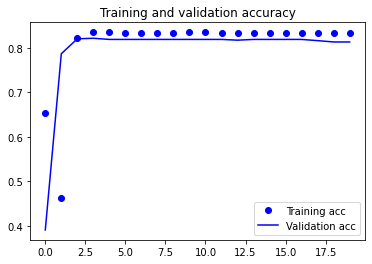

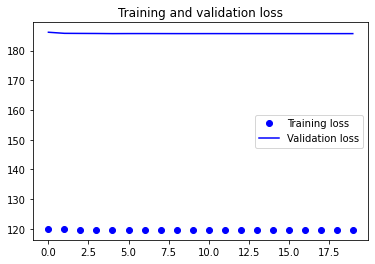

In [81]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def final_predictions(text):
  y_id_to_word = {value: key for key, value in french_tokenizer.word_index.items()}
  y_id_to_word[0] = '<PAD>'

  sentence = [english_tokenizer.word_index[word] for word in text.split()]
  sentence = pad_sequences([sentence], maxlen=preproc_french_sentences.shape[-2], padding='post')
  
  print(sentence.shape)
  print(logits_to_text(simple_rnn_model.predict(sentence[:1])[0], french_tokenizer))

In [ ]:
simple_rnn_model.save('model')

In [ ]:
! mkdir "pickles"

In [ ]:
with open('pickles/french_tokenizer.pickle', 'wb') as handle:
    pickle.dump(french_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('pickles/english_tokenizer.pickle', 'wb') as handle:
    pickle.dump(english_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('pickles/preproc_french_sentences.pickle', 'wb') as handle:
    pickle.dump(preproc_french_sentences, handle, protocol=pickle.HIGHEST_PROTOCOL) 